In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split

In [2]:
df_treino = pd.read_csv('dataset_treino.csv', keep_default_na=False)
df_teste = pd.read_csv('dataset_teste.csv')

## Modelo #1

Epoch 1/30


c:\Users\games\anaconda3\envs\lcd_scaa\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


496/496 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7897 - loss: 0.5297 - val_accuracy: 0.8095 - val_loss: 0.4170
Epoch 2/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8376 - loss: 0.3809 - val_accuracy: 0.8299 - val_loss: 0.3903
Epoch 3/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8555 - loss: 0.3469 - val_accuracy: 0.8345 - val_loss: 0.3627
Epoch 4/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8605 - loss: 0.3248 - val_accuracy: 0.8413 - val_loss: 0.3536
Epoch 5/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8680 - loss: 0.3083 - val_accuracy: 0.8503 - val_loss: 0.3368
Epoch 6/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8729 - loss: 0.2973 - val_accuracy: 0.8571 - val_loss: 0.3342
Epoch 7/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8810 - loss: 0.2887 - val_accuracy: 0.8605 - val_loss: 0.3302
Epoch 8/30
496/496 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8834 - loss: 0.2811 - val_accuracy: 0.8628 - val_

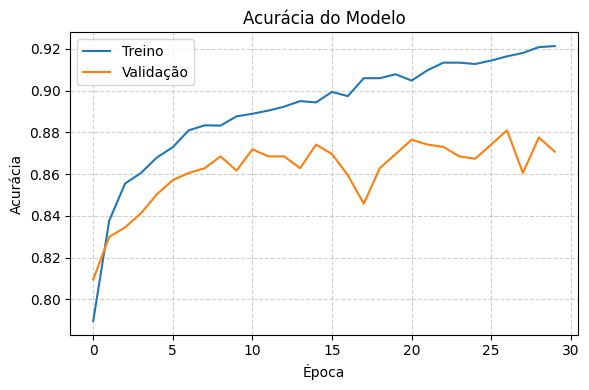

In [7]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

# Copiar o DataFrame original
df = df_treino.copy().drop(columns=['Dia'])

target_col = "Injecao"
encoder = LabelEncoder()
y = encoder.fit_transform(df[target_col])

# Selecionar apenas colunas numéricas como entrada
X = df.drop(columns=['Injecao']).copy()

# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir os dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Número de classes de saída
n_classes = len(np.unique(y))

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

loss, acc = model.evaluate(x_test, y_test)
print(f"\nAcurácia no teste: {acc:.4f}")

preds = model.predict(x_test[:10])
pred_classes = np.argmax(preds, axis=1)

for i, pred in enumerate(pred_classes):
    real = y_test[i]
    print(f"Previsto: {encoder.inverse_transform([pred])[0]} | Real: {encoder.inverse_transform([real])[0]}")

# Gráfico de acurácia
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


             feature  importance
5        Autoconsumo    0.196824
2               Hora    0.107169
3             Normal    0.082668
4   HorarioEconomico    0.055626
11          humidity    0.049365
9           temp_max    0.040472
1                Mes    0.030762
10          pressure    0.014701
14        clouds_all    0.014428
6               temp    0.013612


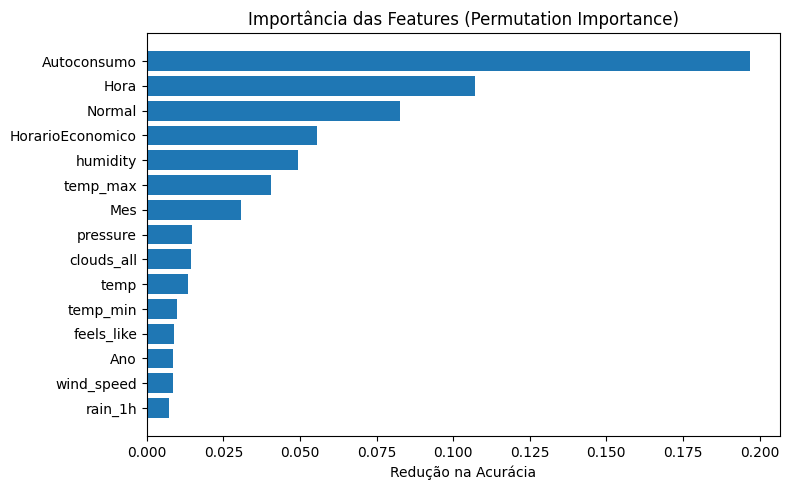

In [8]:
from sklearn.metrics import accuracy_score

def permutation_importance_keras(model, X, y, n_repeats=5):
    baseline = accuracy_score(y, np.argmax(model.predict(X, verbose=0), axis=1))
    importances = np.zeros(X.shape[1])

    for i in range(X.shape[1]):
        scores = []
        X_permuted = X.copy()
        for _ in range(n_repeats):
            np.random.shuffle(X_permuted[:, i])
            y_pred = np.argmax(model.predict(X_permuted, verbose=0), axis=1)
            scores.append(accuracy_score(y, y_pred))
        importances[i] = baseline - np.mean(scores)
    return importances

# calcular importância
importances = permutation_importance_keras(model, x_test.copy(), y_test, n_repeats=5)

# ordenar
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

print(feature_importance.head(10))

# gráfico
plt.figure(figsize=(8, 5))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.gca().invert_yaxis()
plt.title('Importância das Features (Permutation Importance)')
plt.xlabel('Redução na Acurácia')
plt.tight_layout()
plt.show()
